In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import seaborn as sns
import pickle
import math

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 700)

This notebook process the samples for additional SOD labeling from sample_for_additional_labeling.ipynb. It then adds it to the existing SOD-labeled image triplets and saves it as ../data/Gelderman_SOD_cohort/unique_img_triplets_plus.csv. Finally, a dataset for the downstream PMI estimaton task is prepared which includes adding ADD features

In [152]:
# import images with labels which were exported from ICPUTRD
new_labels = pd.read_csv('/home/anau/SOD_labeling/for_PMI_estimation/additional_samples_labeled.csv')
print(new_labels.shape)
display(new_labels.head())

(354, 3)


,image,label,bodypart
0,/anau_img3/a7a/a7a00613.10.icon.JPG,G-2,head
1,/anau_img3/5e3/5e310324.07.icon.JPG,G-2,head
2,/anau_img3/02a/02a00329.15.icon.JPG,G-2,head
3,/anau_img3/bef/bef00604.08.icon.JPG,G-3,head
4,/anau_img3/c75/c7500815.03.icon.JPG,G-2,head


In [153]:
# extract donor_date from img column
new_labels['donor_date'] = new_labels.image.str.split('.', expand=True)[0].str.split('/', expand=True)[3]
display(new_labels.head())

,image,label,bodypart,donor_date
0,/anau_img3/a7a/a7a00613.10.icon.JPG,G-2,head,a7a00613
1,/anau_img3/5e3/5e310324.07.icon.JPG,G-2,head,5e310324
2,/anau_img3/02a/02a00329.15.icon.JPG,G-2,head,02a00329
3,/anau_img3/bef/bef00604.08.icon.JPG,G-3,head,bef00604
4,/anau_img3/c75/c7500815.03.icon.JPG,G-2,head,c7500815


In [154]:
# process label column
new_labels['label'] = new_labels.label.str.split('-', expand=True)[1]
new_labels.head()

,image,label,bodypart,donor_date
0,/anau_img3/a7a/a7a00613.10.icon.JPG,2,head,a7a00613
1,/anau_img3/5e3/5e310324.07.icon.JPG,2,head,5e310324
2,/anau_img3/02a/02a00329.15.icon.JPG,2,head,02a00329
3,/anau_img3/bef/bef00604.08.icon.JPG,3,head,bef00604
4,/anau_img3/c75/c7500815.03.icon.JPG,2,head,c7500815


In [155]:
# converts labels to float
new_labels['label'] = new_labels['label'].astype(float).copy()
new_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       354 non-null    object 
 1   label       327 non-null    float64
 2   bodypart    354 non-null    object 
 3   donor_date  354 non-null    object 
dtypes: float64(1), object(3)
memory usage: 11.2+ KB


In [156]:
new_labels.label.unique()

array([ 2.,  3.,  4., nan,  6.,  5.,  1.])

In [157]:
head_labels = new_labels[new_labels.bodypart == 'head']
torso_labels = new_labels[new_labels.bodypart == 'torso']
limbs_labels = new_labels[new_labels.bodypart == 'limbs']
print(len(head_labels), len(torso_labels), len(limbs_labels))

118 118 118


In [158]:
# align dataframes on donor_date column
head_torso_aligned = pd.merge(head_labels[['donor_date', 'image','label']] , torso_labels[['donor_date', 'image','label']], 
                            how='inner', on='donor_date', suffixes= ('_head', '_torso'))
print(head_torso_aligned.shape)
#display(head_torso_aligned.head())

head_torso_limbs_aligned = pd.merge(head_torso_aligned, limbs_labels[['donor_date', 'image','label']], 
                                  how='inner', on='donor_date')
print(head_torso_limbs_aligned.shape)
display(head_torso_limbs_aligned.head())
display(head_torso_limbs_aligned.info())

(118, 5)
(118, 7)


,donor_date,image_head,label_head,image_torso,label_torso,image,label
0,a7a00613,/anau_img3/a7a/a7a00613.10.icon.JPG,2.0,/anau_img3/a7a/a7a00613.07.icon.JPG,2.0,/anau_img3/a7a/a7a00613.09.icon.JPG,1.0
1,5e310324,/anau_img3/5e3/5e310324.07.icon.JPG,2.0,/anau_img3/5e3/5e310324.22.icon.JPG,2.0,/anau_img3/5e3/5e310324.09.icon.JPG,2.0
2,02a00329,/anau_img3/02a/02a00329.15.icon.JPG,2.0,/anau_img3/02a/02a00329.11.icon.JPG,2.0,/anau_img3/02a/02a00329.19.icon.JPG,2.0
3,bef00604,/anau_img3/bef/bef00604.08.icon.JPG,3.0,/anau_img3/bef/bef00604.11.icon.JPG,1.0,/anau_img3/bef/bef00604.09.icon.JPG,1.0
4,c7500815,/anau_img3/c75/c7500815.03.icon.JPG,2.0,/anau_img3/c75/c7500815.13.icon.JPG,3.0,/anau_img3/c75/c7500815.14.icon.JPG,3.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 118 entries, 0 to 117
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   donor_date   118 non-null    object 
 1   image_head   118 non-null    object 
 2   label_head   113 non-null    float64
 3   image_torso  118 non-null    object 
 4   label_torso  101 non-null    float64
 5   image        118 non-null    object 
 6   label        113 non-null    float64
dtypes: float64(3), object(4)
memory usage: 7.4+ KB


None

In [159]:
new_labels2 = head_torso_limbs_aligned[['donor_date', 'image_head', 'label_head',
                                       'image_torso', 'label_torso',
                                       'image', 'label']].copy()
new_labels2.head()

,donor_date,image_head,label_head,image_torso,label_torso,image,label
0,a7a00613,/anau_img3/a7a/a7a00613.10.icon.JPG,2.0,/anau_img3/a7a/a7a00613.07.icon.JPG,2.0,/anau_img3/a7a/a7a00613.09.icon.JPG,1.0
1,5e310324,/anau_img3/5e3/5e310324.07.icon.JPG,2.0,/anau_img3/5e3/5e310324.22.icon.JPG,2.0,/anau_img3/5e3/5e310324.09.icon.JPG,2.0
2,02a00329,/anau_img3/02a/02a00329.15.icon.JPG,2.0,/anau_img3/02a/02a00329.11.icon.JPG,2.0,/anau_img3/02a/02a00329.19.icon.JPG,2.0
3,bef00604,/anau_img3/bef/bef00604.08.icon.JPG,3.0,/anau_img3/bef/bef00604.11.icon.JPG,1.0,/anau_img3/bef/bef00604.09.icon.JPG,1.0
4,c7500815,/anau_img3/c75/c7500815.03.icon.JPG,2.0,/anau_img3/c75/c7500815.13.icon.JPG,3.0,/anau_img3/c75/c7500815.14.icon.JPG,3.0


In [160]:
# rename some columns
new_labels2.rename(columns={"image_head": "img_head",
                            "label_head": "true_SOD_G_head",
                            "image_torso": "img_torso",
                            "label_torso": "true_SOD_G_torso",
                            "image": "img_limbs",
                            "label": "true_SOD_G_limbs"}, inplace=True)
new_labels2.head()

,donor_date,img_head,true_SOD_G_head,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs
0,a7a00613,/anau_img3/a7a/a7a00613.10.icon.JPG,2.0,/anau_img3/a7a/a7a00613.07.icon.JPG,2.0,/anau_img3/a7a/a7a00613.09.icon.JPG,1.0
1,5e310324,/anau_img3/5e3/5e310324.07.icon.JPG,2.0,/anau_img3/5e3/5e310324.22.icon.JPG,2.0,/anau_img3/5e3/5e310324.09.icon.JPG,2.0
2,02a00329,/anau_img3/02a/02a00329.15.icon.JPG,2.0,/anau_img3/02a/02a00329.11.icon.JPG,2.0,/anau_img3/02a/02a00329.19.icon.JPG,2.0
3,bef00604,/anau_img3/bef/bef00604.08.icon.JPG,3.0,/anau_img3/bef/bef00604.11.icon.JPG,1.0,/anau_img3/bef/bef00604.09.icon.JPG,1.0
4,c7500815,/anau_img3/c75/c7500815.03.icon.JPG,2.0,/anau_img3/c75/c7500815.13.icon.JPG,3.0,/anau_img3/c75/c7500815.14.icon.JPG,3.0


In [161]:
# import new samples (image triplets)
new_samples = pd.read_csv('/data/anau/PMI_estimation/data/Gelderman_SOD_cohort/new_samples.csv')
print(new_samples.shape)
display(new_samples.head())

(118, 31)


,new_id,old_id,img_path,img_head,correct_img_date,date_placed_ARF,PMI_days,year,sex,ancestry,est_stature_cm,est_weight_lb,est_stature_in,age_at_death,true_BP,pred_BP,pred_BP_conf,true_SOD_G_head,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M,donor_date,final_BP,BMI,BMI_status,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs
5323476,a7a,UT55-17D,/da1_data/icputrd/arf/mean.js/public/anau_img3/a7a/a7a00613.10.JPG,a7a00613.10.JPG,2017-06-13,2017-06-13,0.0,2017.0,Male,NaN,170.18,230.0,67.000036,31.0,NaN,head,99.45,NaN,NaN,NaN,NaN,NaN,NaN,a7a00613,head,36.0,obese,a7a00613.07.JPG,NaN,a7a00613.09.JPG,NaN
2853367,5e3,UT13-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/5e3/5e310324.07.JPG,5e310324.07.JPG,2016-03-24,2016-03-23,1.0,2015.0,Female,NaN,165.10,135.0,65.000035,76.0,NaN,head,100.00,NaN,NaN,NaN,NaN,NaN,NaN,5e310324,head,22.5,healthy,5e310324.22.JPG,NaN,5e310324.09.JPG,NaN
142489,02a,UT30-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/02a/02a00329.15.JPG,02a00329.15.JPG,2018-03-29,2018-03-27,2.0,2018.0,Male,white,NaN,315.0,73.000000,64.0,NaN,head,100.00,NaN,NaN,NaN,NaN,NaN,NaN,02a00329,head,41.6,obese,02a00329.11.JPG,NaN,02a00329.19.JPG,NaN
6084167,bef,UT41-16D,/da1_data/icputrd/arf/mean.js/public/anau_img3/bef/bef00604.08.JPG,bef00604.08.JPG,2016-06-04,2016-06-01,3.0,2016.0,Female,NaN,165.10,135.0,65.000035,72.0,NaN,head,96.39,NaN,NaN,NaN,NaN,NaN,NaN,bef00604,head,22.5,healthy,bef00604.11.JPG,NaN,bef00604.09.JPG,NaN
6355573,c75,UT49-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/c75/c7500815.03.JPG,c7500815.03.JPG,2015-08-15,2015-08-11,4.0,2015.0,Male,NaN,180.34,242.0,71.000038,76.0,NaN,head,99.72,NaN,NaN,NaN,NaN,NaN,NaN,c7500815,head,33.7,obese,c7500815.13.JPG,NaN,c7500815.14.JPG,NaN


In [162]:
new_samples_w_labels = pd.merge(new_samples , new_labels2[['donor_date', 'true_SOD_G_head',
                                                           'true_SOD_G_torso', 'true_SOD_G_limbs']], 
                            how='inner', on='donor_date')
print(len(new_samples_w_labels))
display(new_samples_w_labels.head())

118


,new_id,old_id,img_path,img_head,correct_img_date,date_placed_ARF,PMI_days,year,sex,ancestry,est_stature_cm,est_weight_lb,est_stature_in,age_at_death,true_BP,pred_BP,pred_BP_conf,true_SOD_G_head_x,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M,donor_date,final_BP,BMI,BMI_status,img_torso,true_SOD_G_torso_x,img_limbs,true_SOD_G_limbs_x,true_SOD_G_head_y,true_SOD_G_torso_y,true_SOD_G_limbs_y
0,a7a,UT55-17D,/da1_data/icputrd/arf/mean.js/public/anau_img3/a7a/a7a00613.10.JPG,a7a00613.10.JPG,2017-06-13,2017-06-13,0.0,2017.0,Male,NaN,170.18,230.0,67.000036,31.0,NaN,head,99.45,NaN,NaN,NaN,NaN,NaN,NaN,a7a00613,head,36.0,obese,a7a00613.07.JPG,NaN,a7a00613.09.JPG,NaN,2.0,2.0,1.0
1,5e3,UT13-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/5e3/5e310324.07.JPG,5e310324.07.JPG,2016-03-24,2016-03-23,1.0,2015.0,Female,NaN,165.10,135.0,65.000035,76.0,NaN,head,100.00,NaN,NaN,NaN,NaN,NaN,NaN,5e310324,head,22.5,healthy,5e310324.22.JPG,NaN,5e310324.09.JPG,NaN,2.0,2.0,2.0
2,02a,UT30-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/02a/02a00329.15.JPG,02a00329.15.JPG,2018-03-29,2018-03-27,2.0,2018.0,Male,white,NaN,315.0,73.000000,64.0,NaN,head,100.00,NaN,NaN,NaN,NaN,NaN,NaN,02a00329,head,41.6,obese,02a00329.11.JPG,NaN,02a00329.19.JPG,NaN,2.0,2.0,2.0
3,bef,UT41-16D,/da1_data/icputrd/arf/mean.js/public/anau_img3/bef/bef00604.08.JPG,bef00604.08.JPG,2016-06-04,2016-06-01,3.0,2016.0,Female,NaN,165.10,135.0,65.000035,72.0,NaN,head,96.39,NaN,NaN,NaN,NaN,NaN,NaN,bef00604,head,22.5,healthy,bef00604.11.JPG,NaN,bef00604.09.JPG,NaN,3.0,1.0,1.0
4,c75,UT49-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/c75/c7500815.03.JPG,c7500815.03.JPG,2015-08-15,2015-08-11,4.0,2015.0,Male,NaN,180.34,242.0,71.000038,76.0,NaN,head,99.72,NaN,NaN,NaN,NaN,NaN,NaN,c7500815,head,33.7,obese,c7500815.13.JPG,NaN,c7500815.14.JPG,NaN,2.0,3.0,3.0


In [163]:
new_samples_w_labels.drop(['true_SOD_G_head_x', 'true_SOD_G_torso_x', 'true_SOD_G_limbs_x'], 
                          inplace=True,
                         axis=1)
new_samples_w_labels.head()

,new_id,old_id,img_path,img_head,correct_img_date,date_placed_ARF,PMI_days,year,sex,ancestry,est_stature_cm,est_weight_lb,est_stature_in,age_at_death,true_BP,pred_BP,pred_BP_conf,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M,donor_date,final_BP,BMI,BMI_status,img_torso,img_limbs,true_SOD_G_head_y,true_SOD_G_torso_y,true_SOD_G_limbs_y
0,a7a,UT55-17D,/da1_data/icputrd/arf/mean.js/public/anau_img3/a7a/a7a00613.10.JPG,a7a00613.10.JPG,2017-06-13,2017-06-13,0.0,2017.0,Male,NaN,170.18,230.0,67.000036,31.0,NaN,head,99.45,NaN,NaN,NaN,NaN,NaN,a7a00613,head,36.0,obese,a7a00613.07.JPG,a7a00613.09.JPG,2.0,2.0,1.0
1,5e3,UT13-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/5e3/5e310324.07.JPG,5e310324.07.JPG,2016-03-24,2016-03-23,1.0,2015.0,Female,NaN,165.10,135.0,65.000035,76.0,NaN,head,100.00,NaN,NaN,NaN,NaN,NaN,5e310324,head,22.5,healthy,5e310324.22.JPG,5e310324.09.JPG,2.0,2.0,2.0
2,02a,UT30-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/02a/02a00329.15.JPG,02a00329.15.JPG,2018-03-29,2018-03-27,2.0,2018.0,Male,white,NaN,315.0,73.000000,64.0,NaN,head,100.00,NaN,NaN,NaN,NaN,NaN,02a00329,head,41.6,obese,02a00329.11.JPG,02a00329.19.JPG,2.0,2.0,2.0
3,bef,UT41-16D,/da1_data/icputrd/arf/mean.js/public/anau_img3/bef/bef00604.08.JPG,bef00604.08.JPG,2016-06-04,2016-06-01,3.0,2016.0,Female,NaN,165.10,135.0,65.000035,72.0,NaN,head,96.39,NaN,NaN,NaN,NaN,NaN,bef00604,head,22.5,healthy,bef00604.11.JPG,bef00604.09.JPG,3.0,1.0,1.0
4,c75,UT49-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/c75/c7500815.03.JPG,c7500815.03.JPG,2015-08-15,2015-08-11,4.0,2015.0,Male,NaN,180.34,242.0,71.000038,76.0,NaN,head,99.72,NaN,NaN,NaN,NaN,NaN,c7500815,head,33.7,obese,c7500815.13.JPG,c7500815.14.JPG,2.0,3.0,3.0


In [164]:
# rename some columns
new_samples_w_labels.rename(columns={'true_SOD_G_head_y': 'true_SOD_G_head',
                           'true_SOD_G_torso_y': 'true_SOD_G_torso',
                           'true_SOD_G_limbs_y': 'true_SOD_G_limbs'}, inplace=True)
new_samples_w_labels.head()

,new_id,old_id,img_path,img_head,correct_img_date,date_placed_ARF,PMI_days,year,sex,ancestry,est_stature_cm,est_weight_lb,est_stature_in,age_at_death,true_BP,pred_BP,pred_BP_conf,BP_of_true_SOD_G,pred_SOD_G,pred_SOD_G_conf,true_SOD_M,BP_of_true_SOD_M,donor_date,final_BP,BMI,BMI_status,img_torso,img_limbs,true_SOD_G_head,true_SOD_G_torso,true_SOD_G_limbs
0,a7a,UT55-17D,/da1_data/icputrd/arf/mean.js/public/anau_img3/a7a/a7a00613.10.JPG,a7a00613.10.JPG,2017-06-13,2017-06-13,0.0,2017.0,Male,NaN,170.18,230.0,67.000036,31.0,NaN,head,99.45,NaN,NaN,NaN,NaN,NaN,a7a00613,head,36.0,obese,a7a00613.07.JPG,a7a00613.09.JPG,2.0,2.0,1.0
1,5e3,UT13-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/5e3/5e310324.07.JPG,5e310324.07.JPG,2016-03-24,2016-03-23,1.0,2015.0,Female,NaN,165.10,135.0,65.000035,76.0,NaN,head,100.00,NaN,NaN,NaN,NaN,NaN,5e310324,head,22.5,healthy,5e310324.22.JPG,5e310324.09.JPG,2.0,2.0,2.0
2,02a,UT30-18D,/da1_data/icputrd/arf/mean.js/public/anau_img3/02a/02a00329.15.JPG,02a00329.15.JPG,2018-03-29,2018-03-27,2.0,2018.0,Male,white,NaN,315.0,73.000000,64.0,NaN,head,100.00,NaN,NaN,NaN,NaN,NaN,02a00329,head,41.6,obese,02a00329.11.JPG,02a00329.19.JPG,2.0,2.0,2.0
3,bef,UT41-16D,/da1_data/icputrd/arf/mean.js/public/anau_img3/bef/bef00604.08.JPG,bef00604.08.JPG,2016-06-04,2016-06-01,3.0,2016.0,Female,NaN,165.10,135.0,65.000035,72.0,NaN,head,96.39,NaN,NaN,NaN,NaN,NaN,bef00604,head,22.5,healthy,bef00604.11.JPG,bef00604.09.JPG,3.0,1.0,1.0
4,c75,UT49-15D,/da1_data/icputrd/arf/mean.js/public/anau_img3/c75/c7500815.03.JPG,c7500815.03.JPG,2015-08-15,2015-08-11,4.0,2015.0,Male,NaN,180.34,242.0,71.000038,76.0,NaN,head,99.72,NaN,NaN,NaN,NaN,NaN,c7500815,head,33.7,obese,c7500815.13.JPG,c7500815.14.JPG,2.0,3.0,3.0


In [165]:
# drop rows with missing SOD labels
new_samples_w_labels.dropna(subset=['true_SOD_G_head', 'true_SOD_G_torso', 'true_SOD_G_limbs'], inplace=True)
new_samples_w_labels.shape

(95, 31)

In [166]:
new_samples_w_labels.columns

Index(['new_id', 'old_id', 'img_path', 'img_head', 'correct_img_date',
       'date_placed_ARF', 'PMI_days', 'year', 'sex', 'ancestry',
       'est_stature_cm', 'est_weight_lb', 'est_stature_in', 'age_at_death',
       'true_BP', 'pred_BP', 'pred_BP_conf', 'BP_of_true_SOD_G', 'pred_SOD_G',
       'pred_SOD_G_conf', 'true_SOD_M', 'BP_of_true_SOD_M', 'donor_date',
       'final_BP', 'BMI', 'BMI_status', 'img_torso', 'img_limbs',
       'true_SOD_G_head', 'true_SOD_G_torso', 'true_SOD_G_limbs'],
      dtype='object')

## Add new labeled samples to existing Gelderman cohort and analyze

In [167]:
g_data = pd.read_csv('../data/Gelderman_SOD_cohort/unique_img_triplets.csv')
g_data.shape

(174, 16)

In [168]:
g_data.columns

Index(['new_id', 'img_head', 'correct_img_date', 'date_placed_ARF', 'PMI_days',
       'age_at_death', 'sex', 'est_weight_lb', 'est_stature_in',
       'true_SOD_G_head', 'BP_of_true_SOD_G', 'donor_date', 'img_torso',
       'true_SOD_G_torso', 'img_limbs', 'true_SOD_G_limbs'],
      dtype='object')

In [169]:
columns_ls = ['new_id', 'donor_date', 'correct_img_date', 'date_placed_ARF', 'PMI_days',
       'age_at_death', 'sex', 'est_weight_lb', 'est_stature_in',
       'img_head', 'true_SOD_G_head', 'img_torso',
       'true_SOD_G_torso', 'img_limbs', 'true_SOD_G_limbs']

In [170]:
g_data_plus = pd.concat([g_data[columns_ls], 
                         new_samples_w_labels[columns_ls]], axis=0)
print(g_data_plus.shape)
display(g_data_plus.head())
print(g_data_plus.donor_date.nunique())

(269, 15)


,new_id,donor_date,correct_img_date,date_placed_ARF,PMI_days,age_at_death,sex,est_weight_lb,est_stature_in,img_head,true_SOD_G_head,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs
0,004,00400124,2018-01-24,2018-01-09,15.0,77.0,Female,180.0,64.000000,00400124.12.JPG,3.0,00400124.07.JPG,3.0,00400124.10.JPG,3.0
1,006,00600212,2018-02-12,2018-01-09,34.0,81.0,Male,NaN,NaN,00600212.07.JPG,3.0,00600212.25.JPG,3.0,00600212.06.JPG,3.0
2,00b,00b00525,2016-05-25,2016-03-07,79.0,38.0,Male,516.0,73.000039,00b00525.08.JPG,5.0,00b00525.04.JPG,5.0,00b00525.27.JPG,3.0
3,00b,00b00818,2016-08-18,2016-03-07,164.0,38.0,Male,516.0,73.000039,00b00818.07.JPG,6.0,00b00818.05.JPG,6.0,00b00818.11.JPG,3.0
4,00d,00d10116,2019-01-16,2018-11-27,50.0,73.0,Male,235.0,73.000039,00d10116.07.JPG,5.0,00d10116.04.JPG,4.0,00d10116.06.JPG,4.0


268


In [171]:
g_data_plus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269 entries, 0 to 116
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   new_id            269 non-null    object 
 1   donor_date        269 non-null    object 
 2   correct_img_date  269 non-null    object 
 3   date_placed_ARF   269 non-null    object 
 4   PMI_days          269 non-null    float64
 5   age_at_death      268 non-null    float64
 6   sex               268 non-null    object 
 7   est_weight_lb     257 non-null    float64
 8   est_stature_in    263 non-null    float64
 9   img_head          269 non-null    object 
 10  true_SOD_G_head   269 non-null    float64
 11  img_torso         269 non-null    object 
 12  true_SOD_G_torso  269 non-null    float64
 13  img_limbs         269 non-null    object 
 14  true_SOD_G_limbs  269 non-null    float64
dtypes: float64(7), object(8)
memory usage: 33.6+ KB


In [172]:
# drop rows with missing values
g_data_plus.dropna(inplace=True)
g_data_plus.shape

(256, 15)

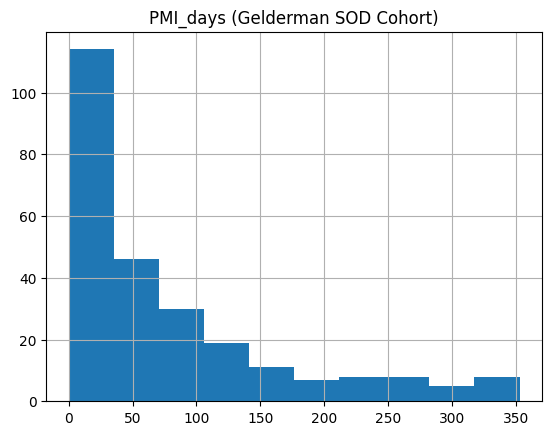

In [173]:
g_data_plus.hist(column='PMI_days')
plt.title('PMI_days (Gelderman SOD Cohort)')
plt.show()

In [174]:
custom_bins = [0,1,2,3,4,5,6,7,8,9,10,  #1
12,14,16,18,20,  #2
23,26,29,32,  #3
36,40,  #4
45,50,  #5
56,61,
68,
76,
85,
95, #10              
106,
118,
131,
145,
160, #15
176,
193,               
211,
230,
250, #20
271,
293,              
316,               
340,
365]

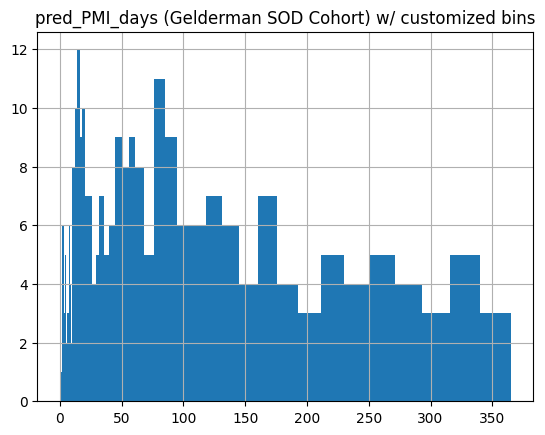

In [175]:
# PMI_days histogram with customized bin widths. 
g_data_plus.hist(column='PMI_days', bins=custom_bins)
plt.title('pred_PMI_days (Gelderman SOD Cohort) w/ customized bins')
plt.show()

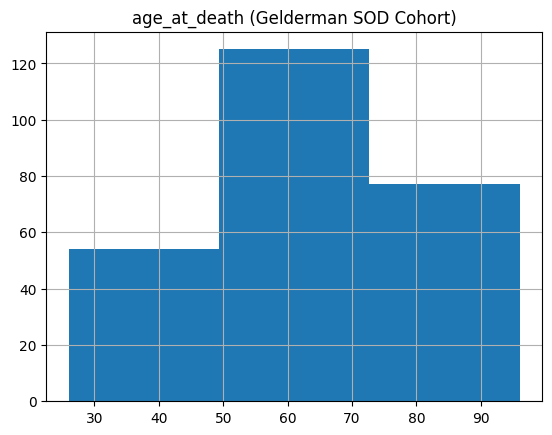

In [176]:
g_data_plus.hist(column='age_at_death', bins=3)
plt.title('age_at_death (Gelderman SOD Cohort)')
plt.show()

In [177]:
g_data_plus.new_id.nunique()

158

In [178]:
g_data_plus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256 entries, 0 to 116
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   new_id            256 non-null    object 
 1   donor_date        256 non-null    object 
 2   correct_img_date  256 non-null    object 
 3   date_placed_ARF   256 non-null    object 
 4   PMI_days          256 non-null    float64
 5   age_at_death      256 non-null    float64
 6   sex               256 non-null    object 
 7   est_weight_lb     256 non-null    float64
 8   est_stature_in    256 non-null    float64
 9   img_head          256 non-null    object 
 10  true_SOD_G_head   256 non-null    float64
 11  img_torso         256 non-null    object 
 12  true_SOD_G_torso  256 non-null    float64
 13  img_limbs         256 non-null    object 
 14  true_SOD_G_limbs  256 non-null    float64
dtypes: float64(7), object(8)
memory usage: 32.0+ KB


In [179]:
g_data_plus.describe()

,PMI_days,age_at_death,est_weight_lb,est_stature_in,true_SOD_G_head,true_SOD_G_torso,true_SOD_G_limbs
count,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000
mean,78.871094,63.972656,188.765625,66.203155,3.761719,3.484375,3.472656
std,87.438959,16.293245,69.435298,8.187923,1.148682,1.058926,1.028627
min,0.000000,26.000000,93.000000,0.000000,1.000000,1.000000,1.000000
25%,15.000000,53.750000,135.000000,64.000035,3.000000,3.000000,3.000000
50%,47.500000,63.000000,180.000000,67.000036,4.000000,3.000000,3.000000
75%,106.750000,76.000000,233.250000,70.000000,5.000000,4.000000,4.000000
max,353.000000,96.000000,516.000000,77.000042,6.000000,6.000000,6.000000


In [148]:
#g_data_plus.to_csv('../data/Gelderman_SOD_cohort/unique_img_triplets_plus.csv', index_label=False)

## Process g_data_plus for downstream PMI estimation task

In [180]:
for_pmi_estimation = g_data_plus.copy()

In [181]:
for_pmi_estimation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256 entries, 0 to 116
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   new_id            256 non-null    object 
 1   donor_date        256 non-null    object 
 2   correct_img_date  256 non-null    object 
 3   date_placed_ARF   256 non-null    object 
 4   PMI_days          256 non-null    float64
 5   age_at_death      256 non-null    float64
 6   sex               256 non-null    object 
 7   est_weight_lb     256 non-null    float64
 8   est_stature_in    256 non-null    float64
 9   img_head          256 non-null    object 
 10  true_SOD_G_head   256 non-null    float64
 11  img_torso         256 non-null    object 
 12  true_SOD_G_torso  256 non-null    float64
 13  img_limbs         256 non-null    object 
 14  true_SOD_G_limbs  256 non-null    float64
dtypes: float64(7), object(8)
memory usage: 32.0+ KB


In [182]:
for_pmi_estimation.describe()

,PMI_days,age_at_death,est_weight_lb,est_stature_in,true_SOD_G_head,true_SOD_G_torso,true_SOD_G_limbs
count,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000
mean,78.871094,63.972656,188.765625,66.203155,3.761719,3.484375,3.472656
std,87.438959,16.293245,69.435298,8.187923,1.148682,1.058926,1.028627
min,0.000000,26.000000,93.000000,0.000000,1.000000,1.000000,1.000000
25%,15.000000,53.750000,135.000000,64.000035,3.000000,3.000000,3.000000
50%,47.500000,63.000000,180.000000,67.000036,4.000000,3.000000,3.000000
75%,106.750000,76.000000,233.250000,70.000000,5.000000,4.000000,4.000000
max,353.000000,96.000000,516.000000,77.000042,6.000000,6.000000,6.000000


In [183]:
# process est_stature_in == 0 (not possible)
display(for_pmi_estimation[for_pmi_estimation.est_stature_in <=50])

,new_id,donor_date,correct_img_date,date_placed_ARF,PMI_days,age_at_death,sex,est_weight_lb,est_stature_in,img_head,true_SOD_G_head,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs
6,01c,01c00405,2018-04-05,2018-01-29,66.0,64.0,Female,157.0,0.0,01c00405.07.JPG,3.0,01c00405.22.JPG,3.0,01c00405.20.JPG,3.0
102,8d3,8d300827,2017-08-27,2017-07-07,51.0,75.0,Female,296.0,0.0,8d300827.08.JPG,5.0,8d300827.05.JPG,4.0,8d300827.03.JPG,3.0
103,8d3,8d300907,2017-09-07,2017-07-07,62.0,75.0,Female,296.0,0.0,8d300907.07.JPG,5.0,8d300907.12.JPG,4.0,8d300907.06.JPG,4.0


In [184]:
# found these values in demo data from mary
for_pmi_estimation.loc[for_pmi_estimation['new_id'] == '01c', 'est_stature_in'] = 60
for_pmi_estimation.loc[for_pmi_estimation['new_id'] == '8d3', 'est_stature_in'] = 65

In [185]:
display(for_pmi_estimation[for_pmi_estimation.donor_date == '01c00405'])
display(for_pmi_estimation[for_pmi_estimation.donor_date == '8d300827'])
display(for_pmi_estimation[for_pmi_estimation.donor_date == '8d300907'])

,new_id,donor_date,correct_img_date,date_placed_ARF,PMI_days,age_at_death,sex,est_weight_lb,est_stature_in,img_head,true_SOD_G_head,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs
6,01c,01c00405,2018-04-05,2018-01-29,66.0,64.0,Female,157.0,60.0,01c00405.07.JPG,3.0,01c00405.22.JPG,3.0,01c00405.20.JPG,3.0


,new_id,donor_date,correct_img_date,date_placed_ARF,PMI_days,age_at_death,sex,est_weight_lb,est_stature_in,img_head,true_SOD_G_head,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs
102,8d3,8d300827,2017-08-27,2017-07-07,51.0,75.0,Female,296.0,65.0,8d300827.08.JPG,5.0,8d300827.05.JPG,4.0,8d300827.03.JPG,3.0


,new_id,donor_date,correct_img_date,date_placed_ARF,PMI_days,age_at_death,sex,est_weight_lb,est_stature_in,img_head,true_SOD_G_head,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs
103,8d3,8d300907,2017-09-07,2017-07-07,62.0,75.0,Female,296.0,65.0,8d300907.07.JPG,5.0,8d300907.12.JPG,4.0,8d300907.06.JPG,4.0


In [186]:
for_pmi_estimation.describe()

,PMI_days,age_at_death,est_weight_lb,est_stature_in,true_SOD_G_head,true_SOD_G_torso,true_SOD_G_limbs
count,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000
mean,78.871094,63.972656,188.765625,66.945343,3.761719,3.484375,3.472656
std,87.438959,16.293245,69.435298,3.884366,1.148682,1.058926,1.028627
min,0.000000,26.000000,93.000000,59.000032,1.000000,1.000000,1.000000
25%,15.000000,53.750000,135.000000,64.000035,3.000000,3.000000,3.000000
50%,47.500000,63.000000,180.000000,67.000036,4.000000,3.000000,3.000000
75%,106.750000,76.000000,233.250000,70.000000,5.000000,4.000000,4.000000
max,353.000000,96.000000,516.000000,77.000042,6.000000,6.000000,6.000000


In [187]:
for_pmi_estimation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256 entries, 0 to 116
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   new_id            256 non-null    object 
 1   donor_date        256 non-null    object 
 2   correct_img_date  256 non-null    object 
 3   date_placed_ARF   256 non-null    object 
 4   PMI_days          256 non-null    float64
 5   age_at_death      256 non-null    float64
 6   sex               256 non-null    object 
 7   est_weight_lb     256 non-null    float64
 8   est_stature_in    256 non-null    float64
 9   img_head          256 non-null    object 
 10  true_SOD_G_head   256 non-null    float64
 11  img_torso         256 non-null    object 
 12  true_SOD_G_torso  256 non-null    float64
 13  img_limbs         256 non-null    object 
 14  true_SOD_G_limbs  256 non-null    float64
dtypes: float64(7), object(8)
memory usage: 32.0+ KB


In [188]:
# change to correct dtypes
for_pmi_estimation['date_placed_ARF'] = pd.to_datetime(for_pmi_estimation['date_placed_ARF'], format='%Y-%m-%d')
for_pmi_estimation['correct_img_date'] = pd.to_datetime(for_pmi_estimation['correct_img_date'],format='%Y-%m-%d')
for_pmi_estimation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256 entries, 0 to 116
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   new_id            256 non-null    object        
 1   donor_date        256 non-null    object        
 2   correct_img_date  256 non-null    datetime64[ns]
 3   date_placed_ARF   256 non-null    datetime64[ns]
 4   PMI_days          256 non-null    float64       
 5   age_at_death      256 non-null    float64       
 6   sex               256 non-null    object        
 7   est_weight_lb     256 non-null    float64       
 8   est_stature_in    256 non-null    float64       
 9   img_head          256 non-null    object        
 10  true_SOD_G_head   256 non-null    float64       
 11  img_torso         256 non-null    object        
 12  true_SOD_G_torso  256 non-null    float64       
 13  img_limbs         256 non-null    object        
 14  true_SOD_G_limbs  256 non-

In [189]:
# sex column to numeric
for_pmi_estimation['sex_male'] = np.where(for_pmi_estimation['sex'] == "Male", 1, 0).copy()
for_pmi_estimation.drop(['sex'], axis=1, inplace=True)
for_pmi_estimation.head()

,new_id,donor_date,correct_img_date,date_placed_ARF,PMI_days,age_at_death,est_weight_lb,est_stature_in,img_head,true_SOD_G_head,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs,sex_male
0,004,00400124,2018-01-24,2018-01-09,15.0,77.0,180.0,64.000000,00400124.12.JPG,3.0,00400124.07.JPG,3.0,00400124.10.JPG,3.0,0
2,00b,00b00525,2016-05-25,2016-03-07,79.0,38.0,516.0,73.000039,00b00525.08.JPG,5.0,00b00525.04.JPG,5.0,00b00525.27.JPG,3.0,1
3,00b,00b00818,2016-08-18,2016-03-07,164.0,38.0,516.0,73.000039,00b00818.07.JPG,6.0,00b00818.05.JPG,6.0,00b00818.11.JPG,3.0,1
4,00d,00d10116,2019-01-16,2018-11-27,50.0,73.0,235.0,73.000039,00d10116.07.JPG,5.0,00d10116.04.JPG,4.0,00d10116.06.JPG,4.0,1
5,011,01101210,2018-12-10,2018-11-29,11.0,90.0,170.0,69.000037,01101210.06.JPG,2.0,01101210.03.JPG,2.0,01101210.08.JPG,2.0,0


In [190]:
# create season_of_recovery
for_pmi_estimation['month'] = for_pmi_estimation['donor_date'].str[-4:-2]
print(for_pmi_estimation.month.unique())

winter = ['12', '01', '02']
spring = ['03', '04', '05']
summer = ['06', '07', '08']
fall = ['09', '10', '11']


conditions = [
    (for_pmi_estimation['month'].isin(winter)),
    (for_pmi_estimation['month'].isin(spring)),
    (for_pmi_estimation['month'].isin(summer)),
    (for_pmi_estimation['month'].isin(fall))
    ]

values = ['winter', 'spring', 'summer', 'fall']

for_pmi_estimation['season_of_recovery'] = np.select(conditions, values)
display(for_pmi_estimation.sample(10))

['01' '05' '08' '12' '04' '03' '07' '06' '02' '09' '10' '11']


,new_id,donor_date,correct_img_date,date_placed_ARF,PMI_days,age_at_death,est_weight_lb,est_stature_in,img_head,true_SOD_G_head,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs,sex_male,month,season_of_recovery
148,cda,cda01009,2017-10-09,2017-08-22,48.0,62.0,180.0,61.000000,cda01009.07.JPG,5.0,cda01009.04.JPG,4.0,cda01009.06.JPG,3.0,0,10,fall
157,dc9,dc901111,2015-11-11,2015-10-08,34.0,85.0,175.0,69.000037,dc901111.13.JPG,4.0,dc901111.65.JPG,3.0,dc901111.05.JPG,3.0,1,11,fall
90,c80,c8000318,2013-03-18,2013-01-23,54.0,41.0,340.0,66.000036,c8000318.33.JPG,3.0,c8000318.09.JPG,3.0,c8000318.13.JPG,3.0,0,03,spring
28,6ce,6ce00718,2012-07-18,2012-02-17,152.0,51.0,234.0,63.000034,6ce00718.26.JPG,4.0,6ce00718.06.JPG,4.0,6ce00718.10.JPG,3.0,0,07,summer
43,843,84301205,2016-12-05,2016-04-06,243.0,69.0,220.0,69.000000,84301205.03.JPG,4.0,84301205.06.JPG,4.0,84301205.07.JPG,3.0,1,12,winter
10,02d,02d00726,2013-07-26,2013-07-03,23.0,80.0,144.0,68.000037,02d00726.34.JPG,6.0,02d00726.08.JPG,6.0,02d00726.13.JPG,6.0,1,07,summer
132,acd,acd01219,2015-12-19,2015-11-20,29.0,60.0,262.0,67.000036,acd01219.08.JPG,3.0,acd01219.05.JPG,3.0,acd01219.07.JPG,3.0,0,12,winter
74,47d,47d00912,2012-09-12,2012-07-16,58.0,63.0,220.0,71.000038,47d00912.28.JPG,5.0,47d00912.04.JPG,4.0,47d00912.08.JPG,5.0,1,09,fall
119,9f7,9f700715,2015-07-15,2015-06-05,40.0,68.0,225.0,72.000039,9f700715.06.JPG,4.0,9f700715.16.JPG,4.0,9f700715.05.JPG,4.0,1,07,summer
26,095,09500709,2013-07-09,2013-06-25,14.0,70.0,190.0,69.000037,09500709.32.JPG,4.0,09500709.06.JPG,5.0,09500709.12.JPG,5.0,1,07,summer


In [191]:
# season_of_recovery to numeric columns
dummies = pd.get_dummies(for_pmi_estimation.season_of_recovery)

# concatenate the dummies to original dataframe
for_pmi_estimation = pd.concat([for_pmi_estimation, dummies], axis='columns').copy()
for_pmi_estimation.head()

# drop the values
for_pmi_estimation.drop(['winter'], axis='columns', inplace=True)
for_pmi_estimation.sample(4)

,new_id,donor_date,correct_img_date,date_placed_ARF,PMI_days,age_at_death,est_weight_lb,est_stature_in,img_head,true_SOD_G_head,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs,sex_male,month,season_of_recovery,fall,spring,summer
134,b49,b4900228,2014-02-28,2014-02-21,7.0,71.0,140.0,60.000032,b4900228.28.JPG,1.0,b4900228.04.JPG,2.0,b4900228.08.JPG,3.0,0,02,winter,0,0,0
103,097,09710121,2015-01-21,2015-01-06,15.0,88.0,100.0,67.000036,09710121.11.JPG,3.0,09710121.17.JPG,3.0,09710121.09.JPG,1.0,0,01,winter,0,0,0
63,2a3,2a300328,2013-03-28,2013-03-09,19.0,47.0,235.0,75.000041,2a300328.30.JPG,4.0,2a300328.06.JPG,3.0,2a300328.10.JPG,4.0,1,03,spring,0,1,0
11,044,04400618,2018-06-18,2018-06-06,12.0,61.0,195.0,69.000037,04400618.06.JPG,3.0,04400618.11.JPG,3.0,04400618.05.JPG,3.0,1,06,summer,0,0,1


In [192]:
for_pmi_estimation.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256 entries, 0 to 116
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   new_id              256 non-null    object        
 1   donor_date          256 non-null    object        
 2   correct_img_date    256 non-null    datetime64[ns]
 3   date_placed_ARF     256 non-null    datetime64[ns]
 4   PMI_days            256 non-null    float64       
 5   age_at_death        256 non-null    float64       
 6   est_weight_lb       256 non-null    float64       
 7   est_stature_in      256 non-null    float64       
 8   img_head            256 non-null    object        
 9   true_SOD_G_head     256 non-null    float64       
 10  img_torso           256 non-null    object        
 11  true_SOD_G_torso    256 non-null    float64       
 12  img_limbs           256 non-null    object        
 13  true_SOD_G_limbs    256 non-null    float64       

## Add ADD features after running add_ADD_ADH_features.ipynb

In [195]:
# import ADD data
with open('./../data/Gelderman_SOD_cohort/unique_donor_date_w_ADD.pkl', 'rb') as f:
        add_data = pickle.load(f)
add_data = pd.DataFrame.from_dict(add_data)
print(add_data.shape)
display(add_data.head())
display(add_data.info())
display(add_data.describe())

(255, 12)


,new_id,donor_date,correct_img_date,date_placed_ARF,PMI_days,ADD_thres0,ADD_thres5,ADD_thres10,ADD_thres15,ADD_thres20,ADD_thres25,ADD_thres30
0,004,00400124,2018-01-24,2018-01-09,15.0,73.881146,65.115868,32.350972,0.000000,0.000000,0.000000,0.00000
1,00b,00b00525,2016-05-25,2016-03-07,79.0,1326.323441,1326.323441,1279.608857,983.358857,391.756402,0.000000,0.00000
2,00b,00b00818,2016-08-18,2016-03-07,164.0,3552.068684,3552.068684,3505.354100,3209.104100,2617.501645,1785.331086,30.05625
3,00d,00d10116,2019-01-16,2018-11-27,50.0,317.835928,268.610789,126.581344,30.420863,0.000000,0.000000,0.00000
4,011,01101210,2018-12-10,2018-11-29,11.0,69.692188,54.013368,39.090451,15.414583,0.000000,0.000000,0.00000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   new_id            255 non-null    object        
 1   donor_date        255 non-null    object        
 2   correct_img_date  255 non-null    datetime64[ns]
 3   date_placed_ARF   255 non-null    datetime64[ns]
 4   PMI_days          255 non-null    float64       
 5   ADD_thres0        255 non-null    float64       
 6   ADD_thres5        255 non-null    float64       
 7   ADD_thres10       255 non-null    float64       
 8   ADD_thres15       255 non-null    float64       
 9   ADD_thres20       255 non-null    float64       
 10  ADD_thres25       255 non-null    float64       
 11  ADD_thres30       255 non-null    float64       
dtypes: datetime64[ns](2), float64(8), object(2)
memory usage: 24.0+ KB


None

,PMI_days,ADD_thres0,ADD_thres5,ADD_thres10,ADD_thres15,ADD_thres20,ADD_thres25,ADD_thres30
count,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000
mean,78.537255,1147.094217,1119.329808,1036.009247,866.946015,633.401283,266.096502,3.110207
std,87.447293,1462.545191,1445.081951,1388.730935,1241.906907,1021.419995,576.873369,13.394212
min,0.000000,0.735417,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,222.781701,206.336285,144.133209,79.505729,0.000000,0.000000,0.000000
50%,47.000000,556.066538,523.898810,463.482986,322.777083,120.377014,0.000000,0.000000
75%,106.000000,1242.111193,1204.607684,1181.980518,997.084091,772.498380,237.312639,0.000000
max,353.000000,5889.655055,5797.420345,5540.646377,4779.720588,3934.570925,2371.437128,126.045139


In [196]:
# join g_data with add_data
for_pmi_estimation2 = pd.merge(for_pmi_estimation, add_data[['donor_date', 'ADD_thres0', 'ADD_thres5', 'ADD_thres10', 'ADD_thres15',
       'ADD_thres20', 'ADD_thres25', 'ADD_thres30']], how='inner', on='donor_date')
print(len(for_pmi_estimation2))
display(for_pmi_estimation2.head())
display(for_pmi_estimation2.info())

256


,new_id,donor_date,correct_img_date,date_placed_ARF,PMI_days,age_at_death,est_weight_lb,est_stature_in,img_head,true_SOD_G_head,img_torso,true_SOD_G_torso,img_limbs,true_SOD_G_limbs,sex_male,month,season_of_recovery,fall,spring,summer,ADD_thres0,ADD_thres5,ADD_thres10,ADD_thres15,ADD_thres20,ADD_thres25,ADD_thres30
0,004,00400124,2018-01-24,2018-01-09,15.0,77.0,180.0,64.000000,00400124.12.JPG,3.0,00400124.07.JPG,3.0,00400124.10.JPG,3.0,0,01,winter,0,0,0,73.881146,65.115868,32.350972,0.000000,0.000000,0.000000,0.00000
1,00b,00b00525,2016-05-25,2016-03-07,79.0,38.0,516.0,73.000039,00b00525.08.JPG,5.0,00b00525.04.JPG,5.0,00b00525.27.JPG,3.0,1,05,spring,0,1,0,1326.323441,1326.323441,1279.608857,983.358857,391.756402,0.000000,0.00000
2,00b,00b00818,2016-08-18,2016-03-07,164.0,38.0,516.0,73.000039,00b00818.07.JPG,6.0,00b00818.05.JPG,6.0,00b00818.11.JPG,3.0,1,08,summer,0,0,1,3552.068684,3552.068684,3505.354100,3209.104100,2617.501645,1785.331086,30.05625
3,00d,00d10116,2019-01-16,2018-11-27,50.0,73.0,235.0,73.000039,00d10116.07.JPG,5.0,00d10116.04.JPG,4.0,00d10116.06.JPG,4.0,1,01,winter,0,0,0,317.835928,268.610789,126.581344,30.420863,0.000000,0.000000,0.00000
4,011,01101210,2018-12-10,2018-11-29,11.0,90.0,170.0,69.000037,01101210.06.JPG,2.0,01101210.03.JPG,2.0,01101210.08.JPG,2.0,0,12,winter,0,0,0,69.692188,54.013368,39.090451,15.414583,0.000000,0.000000,0.00000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 256 entries, 0 to 255
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   new_id              256 non-null    object        
 1   donor_date          256 non-null    object        
 2   correct_img_date    256 non-null    datetime64[ns]
 3   date_placed_ARF     256 non-null    datetime64[ns]
 4   PMI_days            256 non-null    float64       
 5   age_at_death        256 non-null    float64       
 6   est_weight_lb       256 non-null    float64       
 7   est_stature_in      256 non-null    float64       
 8   img_head            256 non-null    object        
 9   true_SOD_G_head     256 non-null    float64       
 10  img_torso           256 non-null    object        
 11  true_SOD_G_torso    256 non-null    float64       
 12  img_limbs           256 non-null    object        
 13  true_SOD_G_limbs    256 non-null    float64       

None

In [197]:
#for_pmi_estimation2.to_pickle('../data/Gelderman_SOD_cohort/for_pmi_estimation.pkl')